# TP3 Reprise de la tâche 3 de l’édition 2009 du DÉfi Fouille de Texte (DEFT):
Apprentissage de classification par parti politique d’interventions au parlement européen

## 1. Load Data

In [3]:
from pathlib import Path
import polars as pl
from bs4 import BeautifulSoup
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

def parse_xml(input_path: Path) -> pl.DataFrame:
    """Parse the input xml into a DataFrame"""
    texts, labels = [], []
    with open(input_path) as f:
        data = BeautifulSoup(f.read(), "lxml-xml")
    for doc in data.find_all("doc"):
        texts.append(doc.find("texte").get_text(strip=True))
        labels.append(doc.find("PARTI")["valeur"])
    return pl.DataFrame({"Text": texts, "Labels": labels})

raw_data = parse_xml("/content/drive/MyDrive/Loic_TP3/deft09_parlement_appr_en.xml")
print(f"Total samples: {len(raw_data)}")
print(raw_data.group_by("Labels").agg(pl.count().alias("count")).sort("count", descending=True))

Mounted at /content/drive
Total samples: 19370
shape: (5, 2)
┌───────────┬───────┐
│ Labels    ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ PPE-DE    ┆ 6858  │
│ PSE       ┆ 5440  │
│ GUE-NGL   ┆ 2688  │
│ Verts-ALE ┆ 2376  │
│ ELDR      ┆ 2008  │
└───────────┴───────┘


/tmp/ipython-input-1954855342.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  print(raw_data.group_by("Labels").agg(pl.count().alias("count")).sort("count", descending=True))


## 2. Data Analysis

/tmp/ipython-input-1761012349.py:25: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  party_doc_counts = raw_data.group_by("Labels").agg(pl.count()).to_dict()


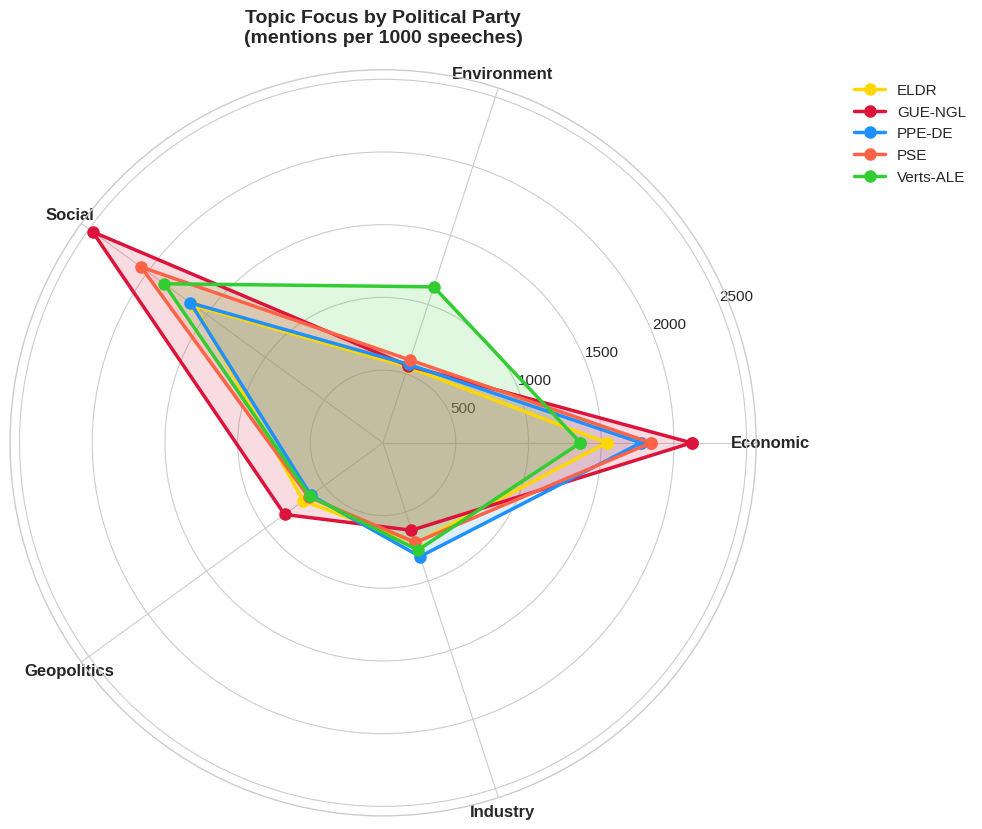

In [4]:
# ============================================================
# 2.1 Radar Chart - Topic Focus by Political Party
# ============================================================

TOPIC_CATEGORIES = {
    'Economic': ['privatisation', 'privatization', 'market', 'public sector', 'government',
                 'investment', 'fund', 'employment', 'unemployment', 'economic', 'economy',
                 'budget', 'fiscal', 'tax', 'trade', 'competition', 'liberalisation', 'growth'],
    'Environment': ['environment', 'environmental', 'climate', 'pollution', 'emission', 'CO2',
                    'energy', 'renewable', 'nuclear', 'sustainable', 'green', 'ecological'],
    'Social': ['human rights', 'rights', 'women', 'gender', 'equality', 'democracy', 'democratic',
               'freedom', 'discrimination', 'social', 'welfare', 'health', 'education', 'workers'],
    'Geopolitics': ['Middle East', 'Asia', 'terrorism', 'terrorist', 'war', 'conflict', 'military',
                    'Russia', 'China', 'USA', 'America', 'Africa', 'NATO', 'UN'],
    'Industry': ['agriculture', 'agricultural', 'farmer', 'fisheries', 'technology', 'innovation',
                 'research', 'science', 'digital', 'industry', 'transport', 'infrastructure']
}

PARTY_COLORS = {
    'ELDR': '#FFD700', 'GUE-NGL': '#DC143C', 'PPE-DE': '#1E90FF',
    'PSE': '#FF6347', 'Verts-ALE': '#32CD32'
}

# Get party counts for normalization
party_doc_counts = raw_data.group_by("Labels").agg(pl.count()).to_dict()
PARTY_COUNTS = dict(zip(party_doc_counts['Labels'], party_doc_counts['count']))
PARTIES = sorted(PARTY_COUNTS.keys())

# Extract keywords
def extract_keywords(text, keyword_list):
    counts = Counter()
    text_lower = text.lower()
    for keyword in keyword_list:
        pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
        matches = re.findall(pattern, text_lower)
        if matches:
            counts[keyword] = len(matches)
    return counts

# Analyze topics
party_topics = {cat: {p: Counter() for p in PARTIES} for cat in TOPIC_CATEGORIES}
for row in raw_data.iter_rows(named=True):
    for cat, keywords in TOPIC_CATEGORIES.items():
        party_topics[cat][row['Labels']].update(extract_keywords(row['Text'], keywords))

# Compute normalized scores
categories = list(TOPIC_CATEGORIES.keys())
party_scores = {p: [sum(party_topics[cat][p].values()) / PARTY_COUNTS[p] * 1000
                    for cat in categories] for p in PARTIES}

# Plot radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for party in PARTIES:
    values = party_scores[party] + [party_scores[party][0]]
    ax.plot(angles, values, 'o-', linewidth=2.5, label=party, color=PARTY_COLORS[party], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=PARTY_COLORS[party])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_title('Topic Focus by Political Party\n(mentions per 1000 speeches)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
plt.tight_layout()
plt.show()


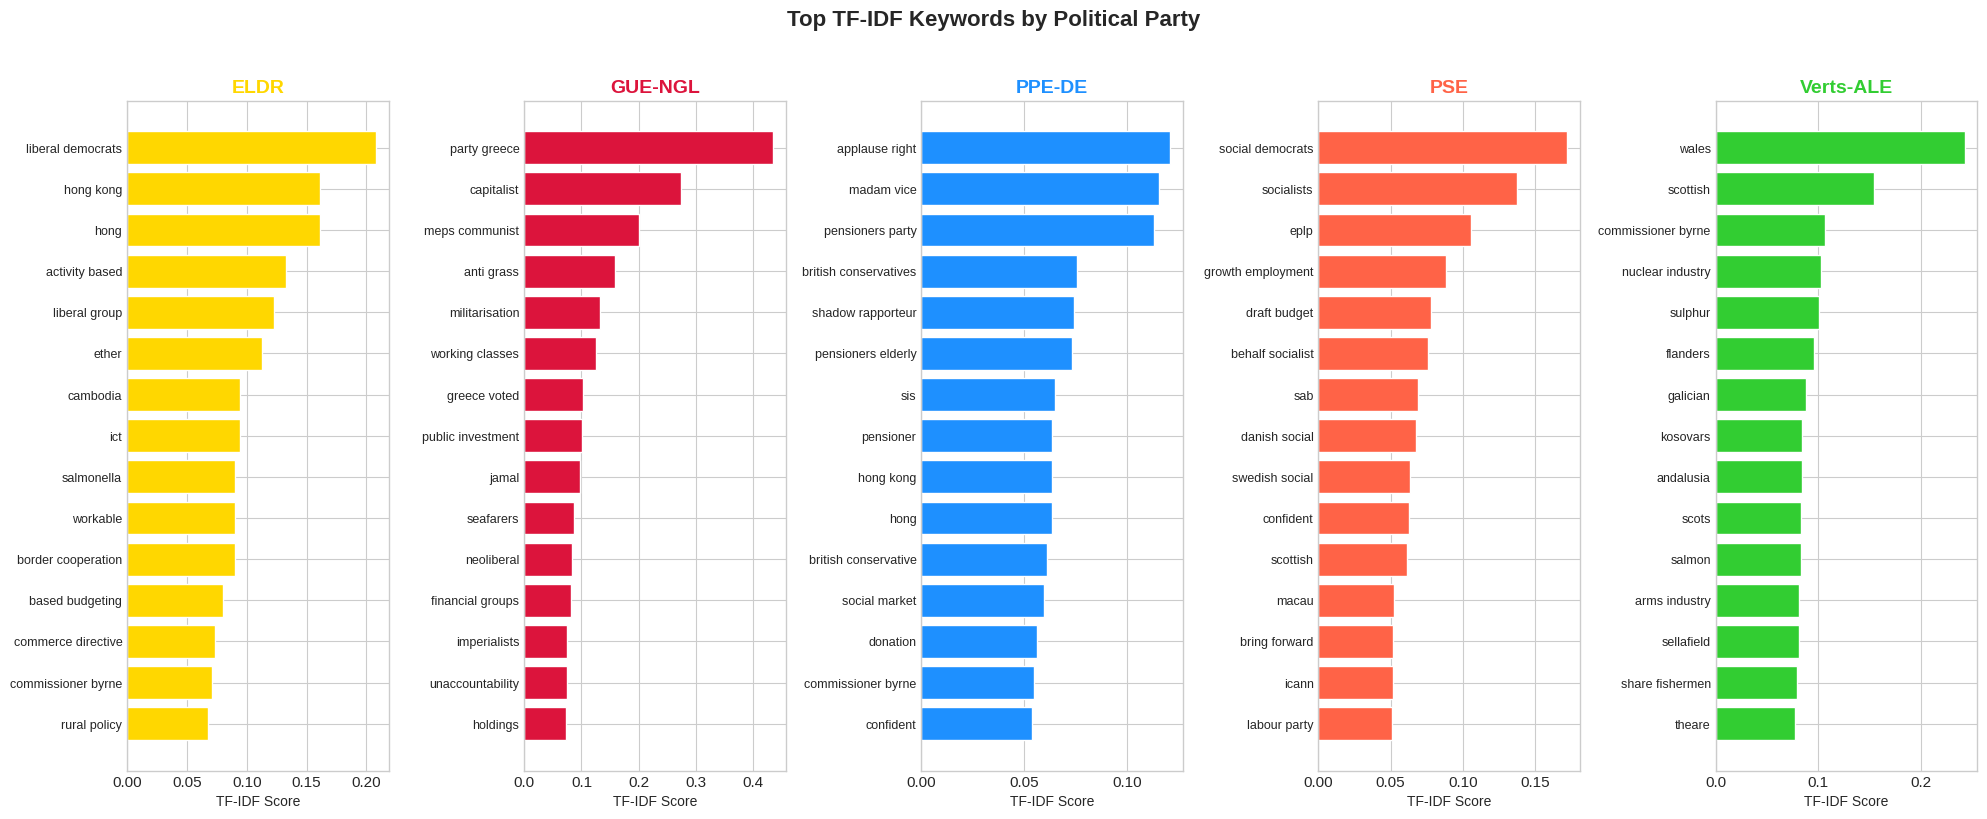

In [5]:
# ============================================================
# 2.2 TF-IDF Top Words by Party
# ============================================================

# Merge all texts per party
party_texts = {p: " ".join(raw_data.filter(pl.col("Labels") == p).get_column("Text").to_list())
               for p in PARTIES}

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, min_df=1, max_df=0.95, stop_words='english',
                             ngram_range=(1, 2), token_pattern=r'\b[a-zA-Z]{3,}\b')
corpus = [party_texts[p] for p in PARTIES]
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# Get top words per party
def get_top_tfidf(party_idx, top_n=15):
    row = tfidf_matrix[party_idx].toarray().flatten()
    return [(feature_names[i], row[i]) for i in row.argsort()[-top_n:][::-1]]

party_top_words = {PARTIES[i]: get_top_tfidf(i, 15) for i in range(len(PARTIES))}

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
for ax, (party, words) in zip(axes, party_top_words.items()):
    labels = [w for w, _ in words][::-1]
    scores = [s for _, s in words][::-1]
    ax.barh(labels, scores, color=PARTY_COLORS[party], edgecolor='white')
    ax.set_xlabel('TF-IDF Score', fontsize=10)
    ax.set_title(party, fontsize=14, fontweight='bold', color=PARTY_COLORS[party])
    ax.tick_params(axis='y', labelsize=9)

plt.suptitle('Top TF-IDF Keywords by Political Party', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



## 4. Model Training


### Baseline model

In [6]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Split data
texts = raw_data.get_column("Text").to_list()
labels = raw_data.get_column("Labels").to_list()

In [8]:
def baseline_model(texts, labels):
    """
    Simple baseline: TF-IDF + Multinomial Naive Bayes

    Args:
        texts: list of text documents
        labels: list of party labels

    Returns:
        dict with accuracy, predictions, and model
    """
    print("=" * 70)
    print("BASELINE MODEL: TF-IDF + Naive Bayes")
    print("=" * 70)

    # Split data
    train_x, test_x, train_y, test_y = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    le = LabelEncoder()
    train_y_enc = le.fit_transform(train_y)
    test_y_enc = le.transform(test_y)
    PARTIES = list(le.classes_)

    print(f"\nDataset split:")
    print(f"  Train: {len(train_x)}")
    print(f"  Test: {len(test_x)}")
    print(f"  Parties: {PARTIES}")

    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', MultinomialNB())
    ])

    # Train
    print("\nTraining...")
    pipeline.fit(train_x, train_y_enc)

    # Predict
    preds = pipeline.predict(test_x)
    acc = accuracy_score(test_y_enc, preds)

    # Evaluate
    print(f"\n" + "=" * 70)
    print(f"TEST ACCURACY: {acc:.4f}")
    print("=" * 70)

    print("\nCLASSIFICATION REPORT:")
    print(classification_report(test_y_enc, preds, target_names=PARTIES))

baseline_model(texts, labels)

BASELINE MODEL: TF-IDF + Naive Bayes

Dataset split:
  Train: 15496
  Test: 3874
  Parties: [np.str_('ELDR'), np.str_('GUE-NGL'), np.str_('PPE-DE'), np.str_('PSE'), np.str_('Verts-ALE')]

Training...

TEST ACCURACY: 0.3673

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        ELDR       0.00      0.00      0.00       402
     GUE-NGL       1.00      0.03      0.05       538
      PPE-DE       0.36      0.99      0.53      1371
         PSE       0.47      0.05      0.09      1088
   Verts-ALE       0.00      0.00      0.00       475

    accuracy                           0.37      3874
   macro avg       0.37      0.21      0.13      3874
weighted avg       0.40      0.37      0.22      3874



### 4.1 SVM with TF-Idf

In [9]:
train_x, test_x, train_y, test_y = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

le = LabelEncoder()
train_y_enc = le.fit_transform(train_y)
test_y_enc = le.transform(test_y)
PARTIES = list(le.classes_)

print(f"Train: {len(train_x)}, Test: {len(test_x)}")
print(f"Parties: {PARTIES}")

# ============================================================
# SVM with TF-IDF
# ============================================================
print("\n" + "=" * 70)
print("STEP 1: Train SVM (TF-IDF + SVM) with Tuned Parameters")
print("=" * 70)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                              sublinear_tf=True, stop_words='english')),
    ('clf', LinearSVC(C=1.0, max_iter=10000, random_state=42))
])

print("\nTraining SVM classifier with best parameters:")
print("  - max_features: 20000")
print("  - ngram_range: (1, 2)")
print("  - sublinear_tf: True")
print("  - C: 1.0")

pipeline.fit(train_x, train_y_enc)
svm_preds = pipeline.predict(test_x)
svm_acc = accuracy_score(test_y_enc, svm_preds)

print(f"\nTest Accuracy (SVM): {svm_acc:.4f}")

print("\n" + "=" * 70)
print("CLASSIFICATION REPORT (SVM + TF-IDF)")
print("=" * 70)
print(classification_report(test_y_enc, svm_preds, target_names=PARTIES))

Train: 15496, Test: 3874
Parties: [np.str_('ELDR'), np.str_('GUE-NGL'), np.str_('PPE-DE'), np.str_('PSE'), np.str_('Verts-ALE')]

STEP 1: Train SVM (TF-IDF + SVM) with Tuned Parameters

Training SVM classifier with best parameters:
  - max_features: 20000
  - ngram_range: (1, 2)
  - sublinear_tf: True
  - C: 1.0

Test Accuracy (SVM): 0.5108

CLASSIFICATION REPORT (SVM + TF-IDF)
              precision    recall  f1-score   support

        ELDR       0.49      0.28      0.36       402
     GUE-NGL       0.65      0.56      0.61       538
      PPE-DE       0.52      0.65      0.58      1371
         PSE       0.45      0.47      0.46      1088
   Verts-ALE       0.47      0.33      0.39       475

    accuracy                           0.51      3874
   macro avg       0.52      0.46      0.48      3874
weighted avg       0.51      0.51      0.50      3874



### 4.2 Word Embedding with MLP

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# ============================================================
# Word Embedding with MLP
# ============================================================
print("\n" + "=" * 70)
print("STEP 2: Word Embedding + PyTorch MLP")
print("=" * 70)

# English semantic embedding model
embed_model = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

# Compute embeddings as torch tensors
print("Computing embeddings for training data...")
train_emb = embed_model.encode(train_x, convert_to_tensor=True, show_progress_bar=True).to(device)
test_emb = embed_model.encode(test_x, convert_to_tensor=True, show_progress_bar=True).to(device)

# Convert labels to torch tensors
train_labels = torch.tensor(np.array(train_y_enc), dtype=torch.long, device=device)
test_labels = torch.tensor(np.array(test_y_enc), dtype=torch.long, device=device)

# DataLoader
batch_size = 32
train_ds = TensorDataset(train_emb, train_labels)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, n_classes=5, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = train_emb.shape[1]
n_classes = len(PARTIES)
model = FeedForwardClassifier(input_dim=input_dim, n_classes=n_classes).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

print(f"\nTraining MLP with embeddings...")
print(f"  - Input dimension: {input_dim}")
print(f"  - Hidden layers: 256 -> 128")
print(f"  - Output classes: {n_classes}")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{epochs} - loss: {epoch_loss:.4f}')

print('Training finished.')

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits = model(test_emb)
    mlp_preds = torch.argmax(logits, dim=1)

mlp_preds_np = mlp_preds.cpu().numpy()
test_y_enc_np = test_labels.cpu().numpy()

mlp_acc = accuracy_score(test_y_enc_np, mlp_preds_np)

print(f"\nTest Accuracy (MLP): {mlp_acc:.4f}")

print("\n" + "=" * 70)
print("CLASSIFICATION REPORT (Embedding + MLP)")
print("=" * 70)
print(classification_report(test_y_enc_np, mlp_preds_np, target_names=PARTIES))

Using device: cuda

STEP 2: Word Embedding + PyTorch MLP


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing embeddings for training data...


Batches:   0%|          | 0/485 [00:00<?, ?it/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]


Training MLP with embeddings...
  - Input dimension: 384
  - Hidden layers: 256 -> 128
  - Output classes: 5
  - Epochs: 20
  - Batch size: 32
Epoch 1/20 - loss: 1.4369
Epoch 5/20 - loss: 1.2766
Epoch 10/20 - loss: 1.0435
Epoch 15/20 - loss: 0.7985
Epoch 20/20 - loss: 0.6065
Training finished.

Test Accuracy (MLP): 0.4004

CLASSIFICATION REPORT (Embedding + MLP)
              precision    recall  f1-score   support

        ELDR       0.25      0.21      0.23       402
     GUE-NGL       0.54      0.36      0.43       538
      PPE-DE       0.45      0.53      0.49      1371
         PSE       0.37      0.40      0.38      1088
   Verts-ALE       0.29      0.25      0.27       475

    accuracy                           0.40      3874
   macro avg       0.38      0.35      0.36      3874
weighted avg       0.40      0.40      0.40      3874

